In [64]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import PIL
import cv2

In [65]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [66]:
path_out = "./Martyna/"
# path_out = "./Maria2/"
# path_out = "./Maria/"
# path_out = "./Wika/"
# path_out = "./Mateusz/"
files = glob.glob(path_out + "*")
files.sort()

In [67]:
dx = 5.106500953873407
dt = 0.0016


data = []
first_filename = files[0]
for file in files:
    data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime(
    "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
)
index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

In [68]:
#     plt.colorbar(label="Intensity")
#     plt.title(title)
#     plt.xlabel("Columns (Space)")
#     plt.ylabel("Rows (Time)")
#     plt.show()

def plot_image(img, a=6, b=9, lines=None, title="DataFrame Visualization", velocities=None):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=img.min().min(), vmax=img.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(img, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            # Annotate velocity
            if velocities is not None:
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(mid_x, mid_y, f"{velocities[i]:.2f} km/h", color="yellow", fontsize=10, ha="center", va="center")


    # plt.colorbar(label='Value')
    plt.title(title)
    if velocities is not None:
        plt.colorbar(label="Intensity")
        plt.xlabel("Columns (Space)")
        plt.ylabel("Rows (Time)")
        plt.axis("on")
    else:
        plt.axis('off')  # Turn off axis labels for better image representation
    # Display the plot
    plt.show()

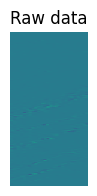

In [69]:
plot_image(df.values, a=1, b=2, title="Raw data")

In [70]:
df = pd.DataFrame(data=data, index=index, columns=columns)
df.shape

(75000, 52)

In [71]:
#downsampling -> decreasing the spatial resolution while keeping the 2D representation of an image
#we downsample the rows
#upsampling -> increasing the spatial resolution while keeping the 2D representation of an image
# #we upsample the columns
# df = pd.DataFrame(data=data, index=index, columns=columns)
# print(f"Shape of the df before downsampling: {df.shape}")

# df = df.reindex(columns=np.arange(df.columns[0], df.columns[-1] + dx, dx / 2)).interpolate(axis=1)
# print(f"Shape of the df after upsampling: {df.shape}")
# df = df[::2]

# print(f"Shape of the df after downsampling: {df.shape}")


#RESIZING =>DECIMATION WITH LANCZOS INTERPOLATION❤️🦎
df = cv2.resize(df.values, (50, 1000), interpolation=cv2.INTER_LANCZOS4)
print(f"Shape of the resized df: {df.shape}")


Shape of the resized df: (1000, 50)


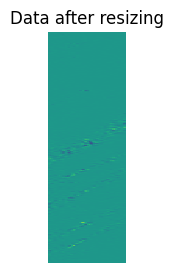

In [72]:
plot_image(df,a=1,b=3, title="Data after resizing")


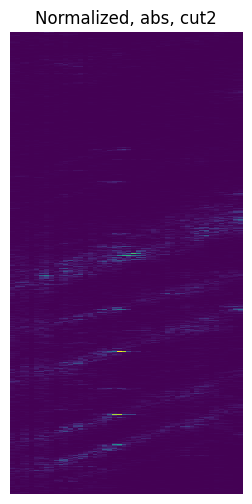

In [73]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
df = pd.DataFrame(df)
df = df.iloc[:, 2:]  #DELETE FIRST 2 COLUMNS, -IT HAS NOISE, AND ITS 
#NOT THAT RELEVANT FOR DETECTION OF LINES❤️🦎

#ARITHMETIC OPERATIONS
df = np.abs(df)  #ABSOLUTELY NECESSARY  ❤️🦎

#NORMALIZE values to 0,255
normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
df = pd.DataFrame(normalized_image)
plot_image(df,a=3, b=6, title="Normalized, abs, cut2")


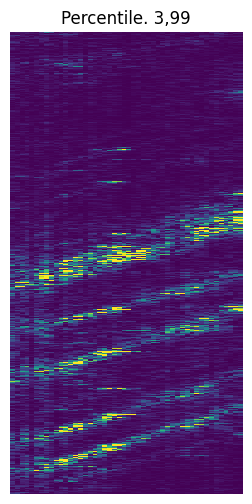

(1000, 48)


In [74]:

#CLIP PERCENTILES FOR OUTLIERS ❤️🦎 - CRUCIAL
low, high = np.percentile(df, [3,99]).astype(np.float32)
df[:] = df.apply(lambda col: np.where(((col < low)), 0, col))
df.clip(upper = high, inplace=True)

plot_image(df.values, a=3,b=6, title="Percentile. 3,99")
print(df.shape)
df_normalized = df

#COLUMN-WISE DENOISING BASED ON MEANS IN COLUMNS AND PERCENTILES
# overall_mean = df_normalized.mean().mean()
# perc = np.percentile(df_normalized.mean(axis=1), 40)
# columns_above = df_normalized.columns[(df_normalized.mean() < perc)]
# df_normalized[columns_above] -= overall_mean
# plot_image(df_normalized.values,3, 6, title="columnwise denois")
df_orginal = df  #NEEDED FOR FINAL VIS ❤️🦎

In [75]:
# df_blurred = cv2.medianBlur(df_normalized.values.astype(np.uint8), 3)
# plot_image(df_blurred, a=3,b=6, title="blurred median whole")


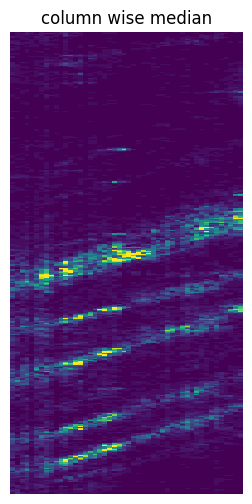

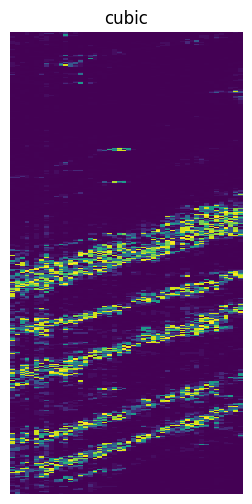

In [76]:

def column_wise_median_filter(df, kernel_size=5):
    """
    Applies a median filter to each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        kernel_size (int): Size of the median filter window (must be odd).
    
    Returns:
        pd.DataFrame: Denoised DataFrame.
    """
    filtered_data = df.copy()
    
    for col in df.columns:
        filtered_data[col] = cv2.medianBlur(df[col].values.astype(np.uint8), kernel_size)
    
    return filtered_data

# Apply the median filter
df_denoised = column_wise_median_filter(df_normalized, kernel_size=5)

# Visualize the result
plot_image(df_denoised.values, a=3, b=6, title="column wise median")
df_squared = df_denoised **3
plot_image(df_squared.values, a=3, b=6, title="cubic")
# print(df_squared.max(axis=1))

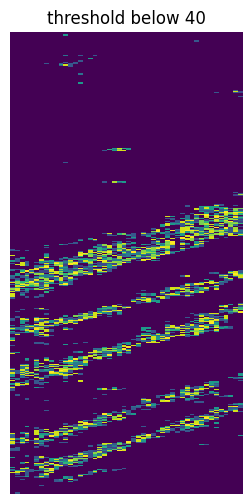

In [77]:
df_squared[:] = df_squared.apply(lambda col: np.where(((col < 40)), 0, col))
plot_image(df_squared.values,3, 6, title="threshold below 40")

In [78]:
# # # CLAHE - reduces contract (yellow) - BAD
# clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(3,10))
# equalized_image = clahe.apply(df_denoised.values)
# df_equalized = pd.DataFrame(equalized_image, columns = df.columns)
# plot_image(df_equalized,3,6,title="CLAHE 2")

In [79]:
#BAD- INDUCES NOISE
# df_normalized = df_normalized.apply(lambda x: x - x.mean())
# print("columnwise normalization")
# plot_image(df_normalized,3, 6)
# df_normalized[:] = df_denoised.apply(lambda col: np.where(((col < 10)), 0, col))
# print("threshold below 20")
# plot_image(df_normalized.values,3, 6)

In [80]:
# #NLM DENOISING
# image = df_denoised.values.astype(np.uint8)
# denoised_image2 = cv2.fastNlMeansDenoising(
#     image,                      
#     h=10,                       
#     templateWindowSize=10,       
#     searchWindowSize=10         
# )
# df2  = pd.DataFrame(denoised_image2, columns=df_normalized.columns)
# plot_image(df2.values, a=3,b=6, title="NLM denoising 10")

In [81]:
# #GAUSSIAN ON 3,21 KERNEL
# kernel = (3,21)
# df_gauss = pd.DataFrame(cv2.GaussianBlur(df.values.astype(np.float32), kernel, 3), columns = df.columns)
# print("Gauss")
# plot_image(df_gauss,3,6)

# kernel = (3,3)
# df_gauss = pd.DataFrame(cv2.GaussianBlur(df2.values.astype(np.float32), kernel, 5), columns = df.columns)
# plot_image(df_gauss.values,a=3,b=6, title="Gauss")

In [82]:
# #THIS IS NICE. IT REMOVES GAUSSIAN-BACKGROUND BLUR, AND THEN IT APPLIES MORE CONTRAST
# background = cv2.GaussianBlur(df_denoised.values.astype(np.uint8), (19,19), 0)
# normalized_image = cv2.subtract(df_denoised.values.astype(np.uint8), background)
# normalized_image = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX)

# df_norm = pd.DataFrame(normalized_image, columns = df.columns)
# plot_image(df_norm.values,a=3,b=6, title="normalized background")

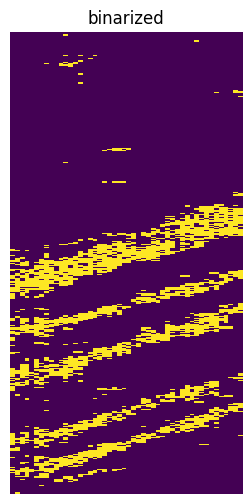

In [83]:
#BINARIZATION
df_binarized = (df_squared > 0).astype(int)
plot_image(df_binarized.values,a=3,b=6, title="binarized")

In [ ]:
# # Perform morphological closing to fill holes in the binary image
# kernel = np.ones((3, 3), np.uint8)  # Define a kernel for the morphological operation
# closed_image = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

print("Connected lines after closing")
# plot_image(closed_image, 3, 6)

In [85]:
# #OPENING FOR NOISE REDUCTION
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# opening = cv2.morphologyEx(closed_image.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=1)
# print("opening")
# plot_image(pd.DataFrame(opening), 3, 6)

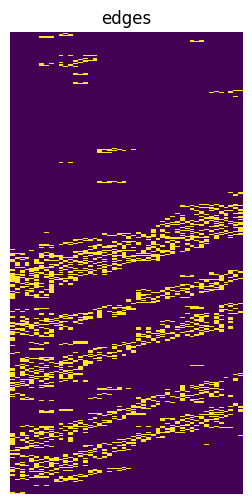

In [86]:
edges = cv2.Canny(df_squared.values.astype(np.uint8), 50, 100)

if edges is not None and np.any(edges):
    edges_df = pd.DataFrame(edges)
    plot_image(edges_df, a=3, b=6, title="edges")
else:
    print("No edges were detected.")

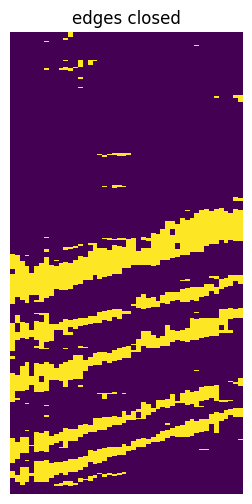

In [87]:
kernel = (3,3)
edges_closed = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=10)
plot_image(edges_closed, a=3, b=6, title="edges closed")

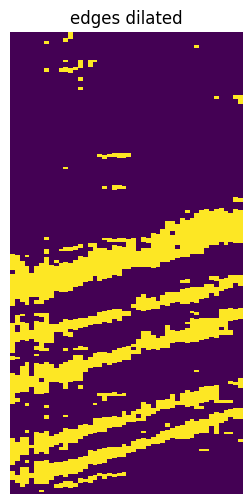

In [88]:
edges_dilated = cv2.dilate(edges_closed, kernel, iterations=4)
plot_image(edges_dilated, 3, 6, title="edges dilated")

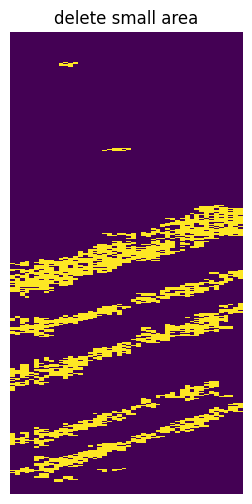

In [89]:
img = df_binarized.values.astype(np.uint8)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)

# Filter out small regions based on area
for label in range(1, num_labels):  # Start from 1 to skip the background
    if stats[label, cv2.CC_STAT_AREA] < 20:
        img[labels == label] = 0
plot_image(img, 3, 6, title="delete small area")

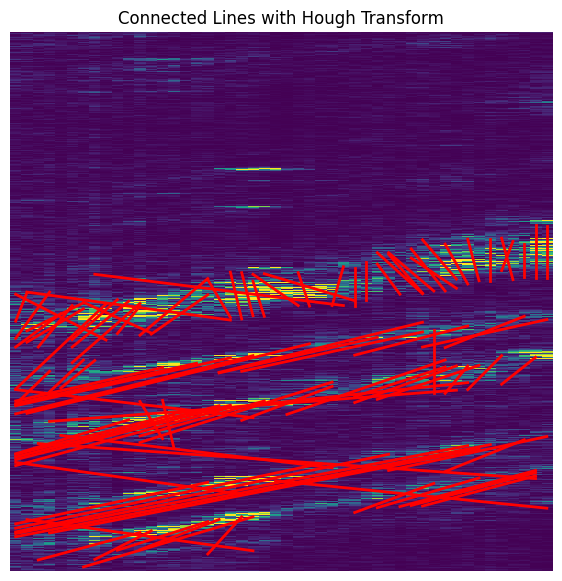

In [102]:
lines = cv2.HoughLinesP(edges_dilated, rho=1, theta=np.pi / 180, threshold=5, minLineLength=50, maxLineGap=20)
plot_image(df_normalized.values, a=7, b= 7, lines = lines, title="Connected Lines with Hough Transform")

In [91]:
# def merge_lines(lines, min_distance=50, max_angle_diff=15):
#     """
#     Groups lines that are close together and have similar angles, then selects
#     the longest, most central line in each group to represent the moving object.

#     Parameters:
#     lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
#     min_distance (float): Minimum distance to consider two lines as part of the same group.
#     max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

#     Returns:
#     list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
#     """
#     if lines is None or len(lines) == 0:
#         return []

#     merged_groups = []

#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
#         length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
#         midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
#         added = False

#         for group in merged_groups:
#             gx1, gy1, gx2, gy2, gangle, glines = group
#             group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
#             group_distance = np.sqrt(
#                 (midpoint[0] - group_midpoint[0]) ** 2
#                 + (midpoint[1] - group_midpoint[1]) ** 2
#             )

#             if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
#                 # Add the line to this group
#                 group[0] = min(gx1, x1, x2)  # Update group boundaries
#                 group[1] = min(gy1, y1, y2)
#                 group[2] = max(gx2, x1, x2)
#                 group[3] = max(gy2, y1, y2)
#                 group[4] = (gangle + angle) / 2  # Average the angles
#                 group[5].append((x1, y1, x2, y2, length, midpoint))  # Add line details
#                 added = True
#                 break

#         if not added:
#             # Create a new group for this line
#             merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2, length, midpoint)]])

#     # Select the longest, most central line from each group
#     selected_lines = []
#     for group in merged_groups:
#         group_lines = group[5]  # All lines in the group
#         group_midpoint = (
#             (group[0] + group[2]) / 2,
#             (group[1] + group[3]) / 2,
#         )  # Group's overall midpoint

#         # Find the line that is the longest and most central
#         def line_score(line):
#             _, _, _, _, length, midpoint = line
#             centrality = -np.sqrt(
#                 (midpoint[0] - group_midpoint[0]) ** 2
#                 + (midpoint[1] - group_midpoint[1]) ** 2
#             )
#             return length, centrality

#         best_line = max(group_lines, key=line_score)
#         selected_lines.append([[best_line[0], best_line[1], best_line[2], best_line[3]]])

#     return selected_lines


In [92]:
def merge_lines(lines, min_distance=50, max_angle_diff=25):
    """
    Groups lines that are close together and have similar angles, then selects
    the line with the most left and most right coordinates in each group.

    Parameters:
    lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
    min_distance (float): Minimum distance to consider two lines as part of the same group.
    max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

    Returns:
    list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
    """
    if lines is None or len(lines) == 0:
        return []

    merged_groups = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
        added = False

        for group in merged_groups:
            gx1, gy1, gx2, gy2, gangle, glines = group
            group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
            group_distance = np.sqrt(
                (midpoint[0] - group_midpoint[0]) ** 2
                + (midpoint[1] - group_midpoint[1]) ** 2
            )

            if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
                # Add the line to this group
                group[0] = min(gx1, x1, x2)  # Update group boundaries
                group[1] = min(gy1, y1, y2)
                group[2] = max(gx2, x1, x2)
                group[3] = max(gy2, y1, y2)
                group[4] = (gangle + angle) / 2  # Average the angles
                group[5].append((x1, y1, x2, y2))  # Add line coordinates
                added = True
                break

        if not added:
            # Create a new group for this line
            merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2)]])

    # Select the line with the most left and most right coordinates from each group
    selected_lines = []
    for group in merged_groups:
        group_lines = group[5]  # All lines in the group

        # Determine the overall leftmost and rightmost points
        leftmost = min((line[0], line[1]) for line in group_lines)
        rightmost = max((line[2], line[3]) for line in group_lines)

        # Form a new line from the leftmost to the rightmost point
        selected_lines.append([[leftmost[0], leftmost[1], rightmost[0], rightmost[1]]])

    return selected_lines


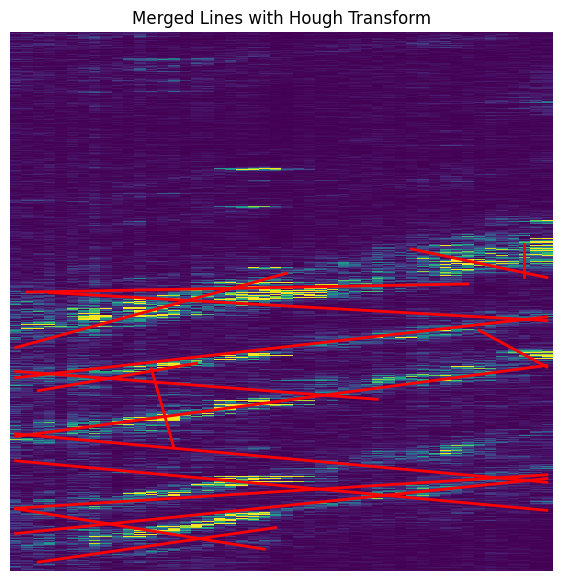

In [93]:
merged_lines = merge_lines(lines)

# Plot merged lines
plot_image(df_orginal.values, a= 7, b= 7, lines = merged_lines, title="Merged Lines with Hough Transform")

In [94]:
df.shape

(1000, 48)

In [95]:
#FAJNY KOD DO USTAWIENIA DX I DT

# Original values
original_dx = 5.106500953873407
original_dt = 0.0016
original_shape = (75000, 52)  # (rows, columns)

# New dataframe shape
new_shape = df.shape  # (rows, columns)

# Calculate new dx and dt
new_dt = original_dt * (original_shape[0] / new_shape[0])
new_dx = original_dx * (original_shape[1] / new_shape[1])

print(f"New dx: {new_dx:.3f} meters/column")
print(f"New dt: {new_dt:.3f} seconds/row")


New dx: 5.532 meters/column
New dt: 0.120 seconds/row


In [96]:
def calculate_velocities(lines, dx, dt):
    """
    Calculate velocities for each line based on its slope.

    Parameters:
        lines (list): List of merged lines in the format [[[x1, y1, x2, y2]], ...].
        dx (float): Spatial resolution (distance per column).
        dt (float): Temporal resolution (time per row).

    Returns:
        list: A list of velocities corresponding to each line.
    """
    velocities = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)  # Slope in pixels
            velocity = abs(dx / (slope * dt)) * 3.6  # Convert to km/h
            velocities.append(velocity)
        else:
            velocities.append(None)  # Vertical line: undefined velocity
    return velocities

velocities = calculate_velocities(merged_lines, new_dx, new_dt)
print(velocities)




[59.092274295769926, 48.68197576025982, 2.257976612256949, 431.49933060230285, None, 69.02814342514716, 125.8093581780908, 76.47235497099638, 37.57613909454017, 28.86283147841491, 14.643642441254624, 84.78456746784379, 54.456045328415634, 86.66866896712921, 140.4287762315187, 102.13001907746815, 45.557998706125495]


TypeError: unsupported format string passed to NoneType.__format__

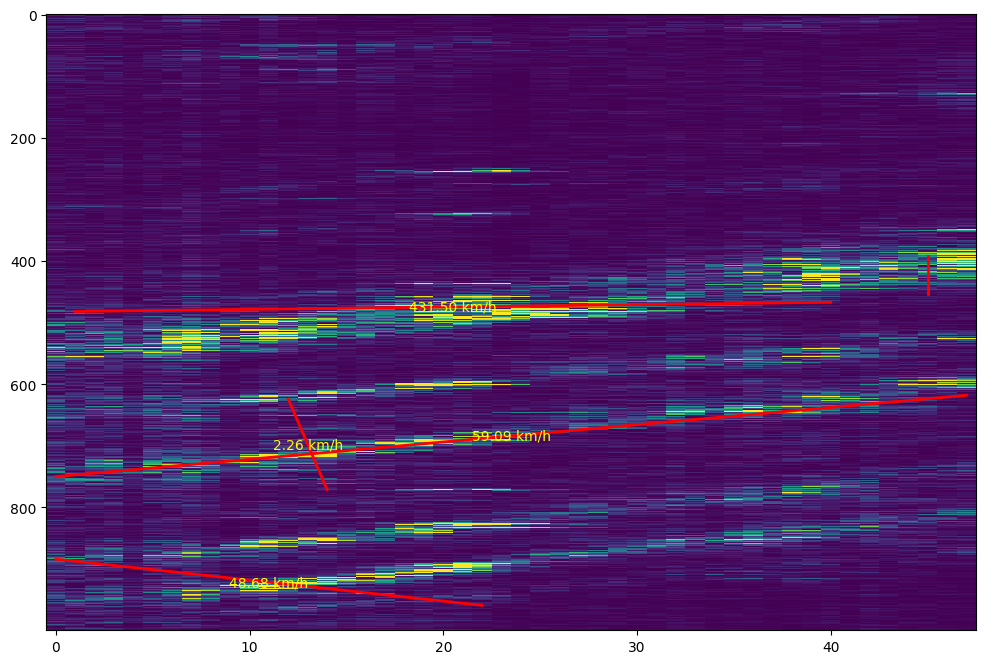

In [97]:
plot_image(df_orginal, a=12,b=8,lines=merged_lines, title="Merged Lines with Velocities",velocities=velocities)

erosion


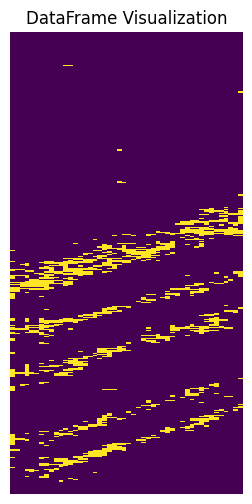

In [ ]:
#EROSION, 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
eroded_image = cv2.erode(df_binarized.values.astype(np.uint8), kernel, iterations=1)
df_eroded = pd.DataFrame(eroded_image, columns=df.columns)
print("erosion")
plot_image(df_eroded,3,6)

dilation


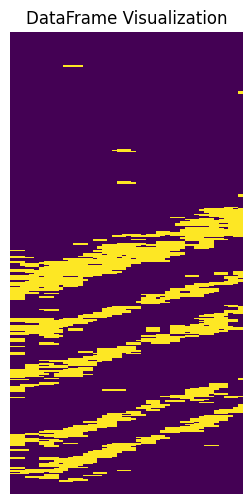

In [ ]:
#DILATION
kernel_diagonal = np.ones((2,2), dtype=np.uint8)
# for i in range(20):
#     kernel_diagonal[i, min(i, 4)] = 1
kernel_flip =  np.flip(kernel_diagonal,axis=1 )
# print(kernel_flip)
img_bin_dil = cv2.dilate(df_eroded.values.astype(np.uint8), kernel_flip, iterations=2)   #i have like 20 pixels gaps on vertical. 
df_dilated = pd.DataFrame(img_bin_dil, columns=df.columns)
print("dilation")
plot_image(df_dilated,3,6)

smooth edges


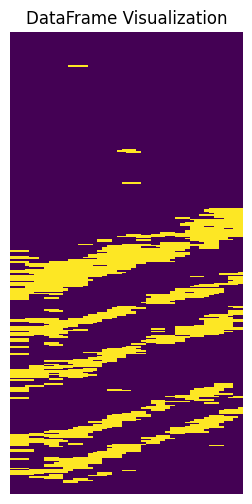

In [ ]:
# CLOSE VERTICAL
vertical_kernel = np.ones((2, 2), dtype=np.uint8)
closed_image = cv2.morphologyEx(df_dilated.values.astype(np.uint8), cv2.MORPH_CLOSE, vertical_kernel)
print("smooth edges")
df_smooth = pd.DataFrame(closed_image, columns = df.columns)
plot_image(df_smooth,3,6)